# Model 2 (D+3)

Alexandre

Here is a research notebook used for tests on predictiv models.

### Import librairies:

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import time
from sklearn.utils import shuffle
from sklearn.model_selection import KFold
import datetime
from keras.utils import to_categorical
from keras.optimizers import RMSprop
from keras.models import load_model
from keras.callbacks import TensorBoard

Using TensorFlow backend.


Install the jupyter-tensorboard extension if needed:

https://github.com/lspvic/jupyter_tensorboard

In [2]:
#%pip install jupyter-tensorboard

Load Tensorboard:

In [3]:
%load_ext tensorboard

### Parameters:

In [4]:
#model
LOAD_MODEL = False 
MODEL_TO_LOAD_NAME = 'model.h5'
PATH_TO_MODELS = "Models/"

#dataset
CSV_PATH = "Datasets/completeDataset/"
CSV_NAME = "completeDataset.csv"
features_considered = ['IQ','pressure','wind_direction','wind_force','humidity','temperature']

### Import dataset and categorize the wind_direction:

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-

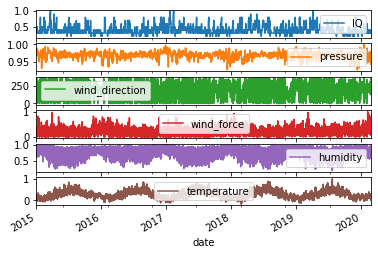

,IQ,pressure,wind_force,humidity,temperature,0,10,20,30,40,...,270,280,290,300,310,320,330,340,350,360
date,,,,,,,,,,,,,,,,,,,,,
2015-01-01 00:00:00+00:00,0.5,0.988013,0.126316,1.00,-0.007246,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2015-01-01 03:00:00+00:00,0.5,0.986958,0.184211,0.95,-0.009662,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2015-01-01 06:00:00+00:00,0.5,0.987629,0.178947,0.94,-0.012077,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2015-01-01 09:00:00+00:00,0.5,0.987821,0.247368,0.85,0.028986,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2015-01-01 12:00:00+00:00,0.5,0.985999,0.336842,0.72,0.099034,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [5]:
df = pd.read_csv(CSV_PATH+CSV_NAME, header=0, delimiter=';')
df['date'] = pd.to_datetime(df['date'],utc=True)

features = df[features_considered]
features.index = df['date']

dataset_test = features.values

def higher_value(features,i):
    return[row[i] for row in dataset_test]

max_pressure = max(higher_value(dataset_test,1))
max_wind_force = max(higher_value(dataset_test,3))
max_temperature = max(higher_value(dataset_test, 5))

#normalize
features['IQ'] = features['IQ'].apply(lambda x: x/10)
features['pressure'] = features['pressure'].apply(lambda x: x/max_pressure)
features['wind_force'] = features['wind_force'].apply(lambda x: x/max_wind_force)
features['humidity'] = features['humidity'].apply(lambda x: x/100)
features['temperature'] = features['temperature'].apply(lambda x: (x-273.15)/(max_temperature-273.15)) 

features.plot(subplots=True)
plt.show()

#wind_direction to categorical
dummy = pd.get_dummies(features['wind_direction'])
windDummy = pd.DataFrame(columns = range(0,361,10))
windDummy[dummy.columns] = dummy.fillna(0)

features = pd.concat([features, windDummy], axis=1)
features = features.drop(columns=["wind_direction"])

features.head()

______________

### Create training data

#### Set the parameters:

In [6]:
#Params
nb_prev_measures_for_predict = 32 # = N in the following explanation

#### Create the train dataset: 
For each day we want to make a prediction of the air quality based on the N previous observation, sarting from the one at 12:00 of this day.

In [7]:
x_train = []
y_train = []
countRow=0

for indexRow, rowx in features.iterrows():
    # for each day we found with a value at 12:00
    if indexRow.hour == 12 and countRow >= nb_prev_measures_for_predict:
        try:
            # indexes for x (the range is inversed as our data are from the oldest to the newest)
            batchX = range(countRow, countRow - nb_prev_measures_for_predict, -1)
            # indexes for y
            batchY = [countRow+8,countRow+16,countRow+24]

            #application
            y_train.append(features.iloc[batchY]["IQ"].values)
            x_train.append(features.iloc[batchX].values)
        except:
            print("To long for ",indexRow)
    countRow+=1
    
x_train = np.array(x_train)
y_train = np.array(y_train)
y_train = y_train.reshape(y_train.shape[0],3,1)
print("x_train :",x_train.shape)
print("y_train :",y_train.shape)

To long for  2020-02-27 12:00:00+00:00
To long for  2020-02-28 12:00:00+00:00
To long for  2020-02-29 12:00:00+00:00
x_train : (1877, 32, 42)
y_train : (1877, 3, 1)


____________________________________

### Load the model or create it:

In [8]:
import tensorflow as tf
from tensorflow import keras
from keras.models import Model
from keras.layers import LSTM, Dense, Input, GRU, BatchNormalization, Dropout
from keras.models import save_model

In [9]:
OPTIMIZER = "Adam"
hiddenUnit = 512
denseSize = 512

if LOAD_MODEL: 
    model = load_model(PATH_TO_MODELS + MODEL_TO_LOAD_NAME)
    model.compile(OPTIMIZER, loss=LOSS)
else:
    # Model
    input_shape = (x_train.shape[-2],x_train.shape[-1])
    inp = Input(input_shape)
    _ = GRU(hiddenUnit,input_shape=input_shape,name='GRUcommonLayer')(inp)
    _ = Dense(denseSize,name="intermediateDenseLayer")(_)
    _ = Dropout(0.3)(_)

    outD1 = Dense(1,name="D1")(_)
    outD2 = Dense(1,name="D2")(_)
    outD3 = Dense(1,name="D3")(_)
    
    model = Model(inputs=[inp], outputs=[outD1, outD2, outD3])    
    model.compile(optimizer=OPTIMIZER, loss={'D1': 'mse', 'D2': 'mse', 'D3': 'mse'}, metrics={'D1': 'mae', 'D2': 'mae', 'D3': 'mae'})
    model.summary()





Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 32, 42)       0                                            
__________________________________________________________________________________________________
GRUcommonLayer (GRU)            (None, 512)          852480      input_1[0][0]                    
__________________________________________________________________________________________________
intermediateDenseLayer (Dense)  (None, 512)          262656      GRUcommonLayer[0][0]             
__________________________________________________________________________________________________
dropout_1 (Dropout)             (None, 512)          0           intermediateDenseLayer[

### Train

In [10]:
EPOCHS = 20
kfoldsize = 5

callbackName = str('.\logs\\'+str(datetime.datetime.now().strftime("%Y-%m-%d_%H-%M-%S")))
tensor_board = TensorBoard(callbackName)

for train_index,test_index in KFold(kfoldsize).split(x_train):
    x,x_val = x_train[train_index],x_train[test_index]
    y,y_val = y_train[train_index],y_train[test_index]
    
    hist = model.fit(x=x, y=[y[:,0],y[:,1],y[:,2]], validation_data=(x_val,[y_val[:,0],y_val[:,1],y_val[:,2]]),epochs=EPOCHS,callbacks = [tensor_board],verbose=2)
    save_model(model,"Models/model"+str(datetime.datetime.now().strftime("%Y-%m-%d_%H-%M-%S"))+".h5")

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where

Train on 1501 samples, validate on 376 samples


Epoch 1/20
 - 7s - loss: 0.0922 - D1_loss: 0.0302 - D2_loss: 0.0331 - D3_loss: 0.0289 - D1_mean_absolute_error: 0.1279 - D2_mean_absolute_error: 0.1358 - D3_mean_absolute_error: 0.1294 - val_loss: 0.0578 - val_D1_loss: 0.0192 - val_D2_loss: 0.0184 - val_D3_loss: 0.0201 - val_D1_mean_absolute_error: 0.1066 - val_D2_mean_absolute_error: 0.1033 - val_D3_mean_absolute_error: 0.1009
Epoch 2/20
 - 6s - loss: 0.0647 - D1_loss: 0.0213 - D2_loss: 0.0213 - D3_loss: 0.0221 - D1_mean_absolute_error: 0.1123 - D2_mean_absolute_error: 0.1128 - D3_mean_absolute_error: 0.1144 - val_loss: 0.0612 - val_D1_loss: 0.0192 - val_D2_loss: 0.0204 - val_D3_loss: 0.0217 - val_D1_mean_absolute_error: 0.0988 - val_D2_mean_absolute_error: 0.1108 - val_D3_mean_absolute_error: 0.1066
Epoch 3/20
 - 6s - loss: 0.0616 - D1_loss: 0.0196 - D2_loss: 0.0205 - D3_loss: 0.0216 - D1_mea

Epoch 20/20
 - 8s - loss: 0.0360 - D1_loss: 0.0111 - D2_loss: 0.0118 - D3_loss: 0.0131 - D1_mean_absolute_error: 0.0815 - D2_mean_absolute_error: 0.0833 - D3_mean_absolute_error: 0.0875 - val_loss: 0.0607 - val_D1_loss: 0.0180 - val_D2_loss: 0.0213 - val_D3_loss: 0.0214 - val_D1_mean_absolute_error: 0.0998 - val_D2_mean_absolute_error: 0.1039 - val_D3_mean_absolute_error: 0.1015
Train on 1501 samples, validate on 376 samples
Epoch 1/20
 - 8s - loss: 0.0388 - D1_loss: 0.0116 - D2_loss: 0.0125 - D3_loss: 0.0147 - D1_mean_absolute_error: 0.0814 - D2_mean_absolute_error: 0.0846 - D3_mean_absolute_error: 0.0909 - val_loss: 0.0366 - val_D1_loss: 0.0104 - val_D2_loss: 0.0114 - val_D3_loss: 0.0149 - val_D1_mean_absolute_error: 0.0791 - val_D2_mean_absolute_error: 0.0838 - val_D3_mean_absolute_error: 0.0933
Epoch 2/20
 - 11s - loss: 0.0347 - D1_loss: 0.0101 - D2_loss: 0.0112 - D3_loss: 0.0134 - D1_mean_absolute_error: 0.0771 - D2_mean_absolute_error: 0.0797 - D3_mean_absolute_error: 0.0878 - va

Epoch 2/20
 - 6s - loss: 0.0198 - D1_loss: 0.0064 - D2_loss: 0.0059 - D3_loss: 0.0075 - D1_mean_absolute_error: 0.0618 - D2_mean_absolute_error: 0.0584 - D3_mean_absolute_error: 0.0673 - val_loss: 0.0143 - val_D1_loss: 0.0050 - val_D2_loss: 0.0042 - val_D3_loss: 0.0051 - val_D1_mean_absolute_error: 0.0556 - val_D2_mean_absolute_error: 0.0510 - val_D3_mean_absolute_error: 0.0568
Epoch 3/20
 - 6s - loss: 0.0151 - D1_loss: 0.0052 - D2_loss: 0.0047 - D3_loss: 0.0052 - D1_mean_absolute_error: 0.0556 - D2_mean_absolute_error: 0.0531 - D3_mean_absolute_error: 0.0552 - val_loss: 0.0150 - val_D1_loss: 0.0049 - val_D2_loss: 0.0046 - val_D3_loss: 0.0055 - val_D1_mean_absolute_error: 0.0557 - val_D2_mean_absolute_error: 0.0538 - val_D3_mean_absolute_error: 0.0596
Epoch 4/20
 - 7s - loss: 0.0134 - D1_loss: 0.0050 - D2_loss: 0.0039 - D3_loss: 0.0044 - D1_mean_absolute_error: 0.0547 - D2_mean_absolute_error: 0.0490 - D3_mean_absolute_error: 0.0517 - val_loss: 0.0158 - val_D1_loss: 0.0053 - val_D2_los

Epoch 4/20
 - 8s - loss: 0.0056 - D1_loss: 0.0021 - D2_loss: 0.0017 - D3_loss: 0.0018 - D1_mean_absolute_error: 0.0355 - D2_mean_absolute_error: 0.0323 - D3_mean_absolute_error: 0.0326 - val_loss: 0.0063 - val_D1_loss: 0.0022 - val_D2_loss: 0.0018 - val_D3_loss: 0.0023 - val_D1_mean_absolute_error: 0.0376 - val_D2_mean_absolute_error: 0.0333 - val_D3_mean_absolute_error: 0.0379
Epoch 5/20
 - 8s - loss: 0.0056 - D1_loss: 0.0019 - D2_loss: 0.0018 - D3_loss: 0.0018 - D1_mean_absolute_error: 0.0342 - D2_mean_absolute_error: 0.0326 - D3_mean_absolute_error: 0.0328 - val_loss: 0.0056 - val_D1_loss: 0.0021 - val_D2_loss: 0.0017 - val_D3_loss: 0.0018 - val_D1_mean_absolute_error: 0.0360 - val_D2_mean_absolute_error: 0.0329 - val_D3_mean_absolute_error: 0.0334
Epoch 6/20
 - 8s - loss: 0.0045 - D1_loss: 0.0017 - D2_loss: 0.0014 - D3_loss: 0.0013 - D1_mean_absolute_error: 0.0322 - D2_mean_absolute_error: 0.0289 - D3_mean_absolute_error: 0.0285 - val_loss: 0.0058 - val_D1_loss: 0.0020 - val_D2_los

Epoch 5/20
 - 6s - loss: 0.0028 - D1_loss: 9.6306e-04 - D2_loss: 8.8154e-04 - D3_loss: 9.9992e-04 - D1_mean_absolute_error: 0.0239 - D2_mean_absolute_error: 0.0229 - D3_mean_absolute_error: 0.0245 - val_loss: 0.0021 - val_D1_loss: 6.2866e-04 - val_D2_loss: 7.2656e-04 - val_D3_loss: 7.0470e-04 - val_D1_mean_absolute_error: 0.0198 - val_D2_mean_absolute_error: 0.0211 - val_D3_mean_absolute_error: 0.0206
Epoch 6/20
 - 9s - loss: 0.0025 - D1_loss: 9.1813e-04 - D2_loss: 7.5611e-04 - D3_loss: 8.0838e-04 - D1_mean_absolute_error: 0.0234 - D2_mean_absolute_error: 0.0215 - D3_mean_absolute_error: 0.0221 - val_loss: 0.0021 - val_D1_loss: 7.0371e-04 - val_D2_loss: 7.3513e-04 - val_D3_loss: 6.3620e-04 - val_D1_mean_absolute_error: 0.0207 - val_D2_mean_absolute_error: 0.0210 - val_D3_mean_absolute_error: 0.0196
Epoch 7/20
 - 9s - loss: 0.0027 - D1_loss: 9.3455e-04 - D2_loss: 8.2632e-04 - D3_loss: 9.7433e-04 - D1_mean_absolute_error: 0.0237 - D2_mean_absolute_error: 0.0225 - D3_mean_absolute_error: 

________________

### See the training in tensorboard

In [11]:
#%tensorboard --logdir=./logs

In [12]:
def calc_accuracy_3days(y_pred,y_true):
    """
    calculate the accurracy of the prediction according to the true value for each day [D+1, D+2, D+3]
    """
    accuracy = [0,0,0]
    for pred,true in zip (y_pred,y_true):
        for plusDay in range(3):
            if true[plusDay] == np.around(pred[plusDay],2):
                accuracy[plusDay]+=1
    return(np.array(accuracy)/len(y_true)*100)

Calculate the accuracy and mean error for each day [D+1, D+2, D+3]:

In [13]:
y_pred = model.predict(x_train)

y_train_visual = np.array(y_train)
y_pred_visual = np.array(y_pred).reshape(y_train_visual.shape)

accuracy = calc_accuracy_3days(y_pred_visual,y_train_visual)

Show the results in graphs:

In [14]:
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = (16,7)

Prediction of the air index quality


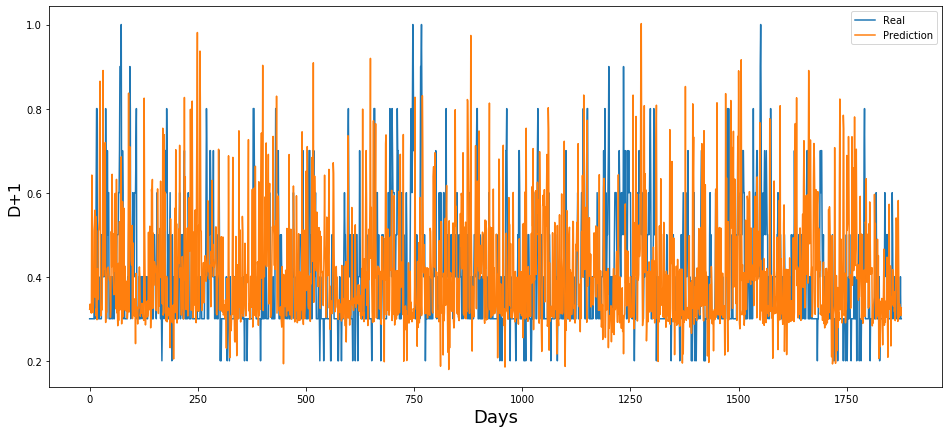

Accuracy :  0.31966
val_D1_loss 0.00128
val_D1_mean_absolute_error 0.02822
D1_loss 0.00066
D1_mean_absolute_error 0.01976


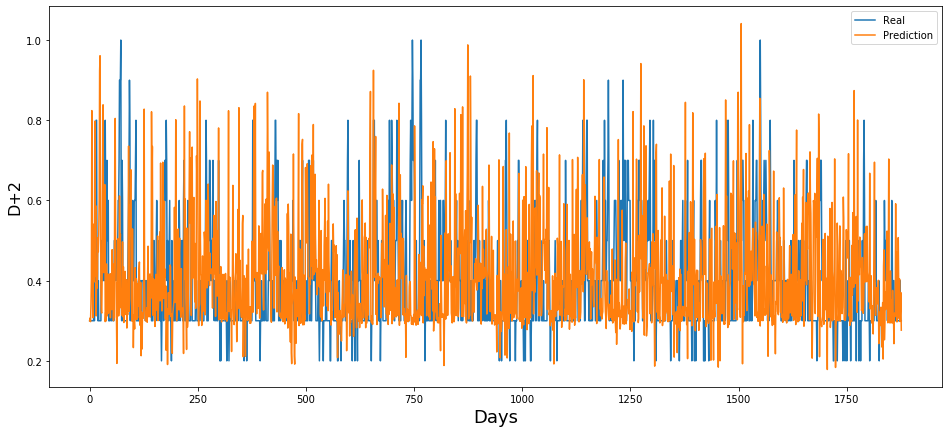

Accuracy :  0.21311
val_D2_loss 0.00113
val_D2_mean_absolute_error 0.02632
D2_loss 0.00065
D2_mean_absolute_error 0.01936


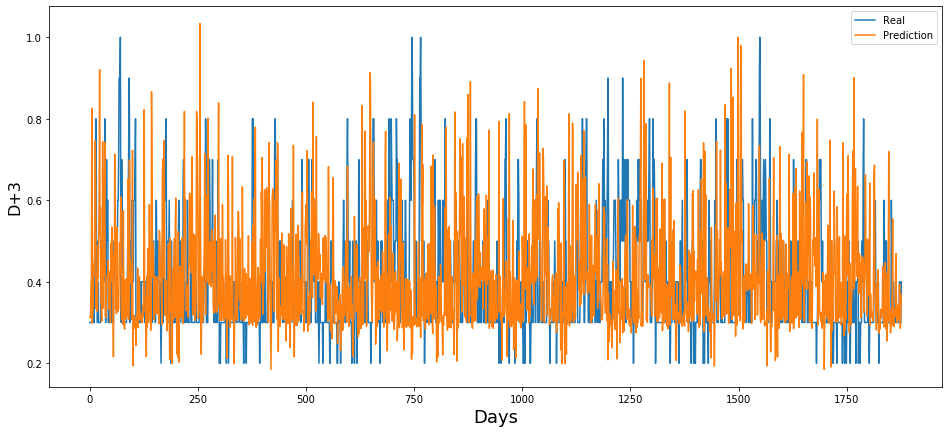

Accuracy :  0.42621
val_D3_loss 0.00105
val_D3_mean_absolute_error 0.02582
D3_loss 0.00068
D3_mean_absolute_error 0.0199


In [15]:
print('Prediction of the air index quality')
for plusDay in range(3):
    #plot predict    
    plt.plot(y_train_visual[:,plusDay], label='Real')
    plt.plot(y_pred_visual[:,plusDay], label='Prediction')
    plt.xlabel('Days', fontsize=18)
    plt.ylabel('D+'+str(plusDay+1), fontsize=16)
    plt.legend()
    plt.show()
    print("Accuracy : ",round(accuracy[plusDay],5))
    for measureName in hist.history:
        if "D"+str(plusDay+1) in measureName:
            print(measureName,round(hist.history[measureName][-1],5))